### Directions

Užduotis: pasinaudojant bank-additional-full.csv sukurti modelį, kuris gali nuspėti ar vartotojas paims terminuotą indėlį.

Visas procesas turi būti aprašytas pasinaudojant Jupyter Notebook. Įsivaizduok, kad aš esu banko darbuotojas ir užsakiau tave modeliui sukurti - tikiuosi __dokumentacijos ir paaiškinimų__ komentarų pavidalu. Spalio 4 dieną bus peer-review užduoties peržiūra, pristatymo ruošti nereikia - jos metu vertinsite vieni kitų darbus ir rinksime favoritus.

Patarimai:
- Duomenų skaitymui ir apdorojimui naudok pandas. Modeliavimui pravers scikit-learn.
- Peržiūrėjęs kintamuosius sugalvok kaip reprezentuoti tekstines vertes, kad šios būtų tinkamos modeliui.
- Patariu peržiūrėti distribucijas (nupaišiant histogramas) ir gavus šiek tiek intuicijos sukurti naujų stulpelių kombinuojant esamus.
- Prieš treniruodamas modelius atidėk dalį jų modelių testavimui.
- Išbandyk ir palygink logistinę regresiją, paprastus medžius ir random forests.
- Kiekvienam modeliui pavaizduok confusion matrix.
- Teigiamas signalas (paimtas indėlis) sudaro ~11% duomenų eilučių, ar tai sukelia problemų modeliui? Kaip galėtum jam pagelbėti?
- Kaip interpretuotum precision ir recall iš biznio perspektyvos? Kokias rekomendacijas atiduotum bankui drauge su savo modeliu?

### Setup

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df = pd.read_csv('C:\\Users\\mazas\\Downloads\\bank-additional-full.csv', sep=';')

#Remove 'duration' column
df.drop(['duration'], axis=1, inplace=True)

### Categorical columns visualization

In [41]:
category_columns = df.select_dtypes(include=['object', 'bool']).columns.values

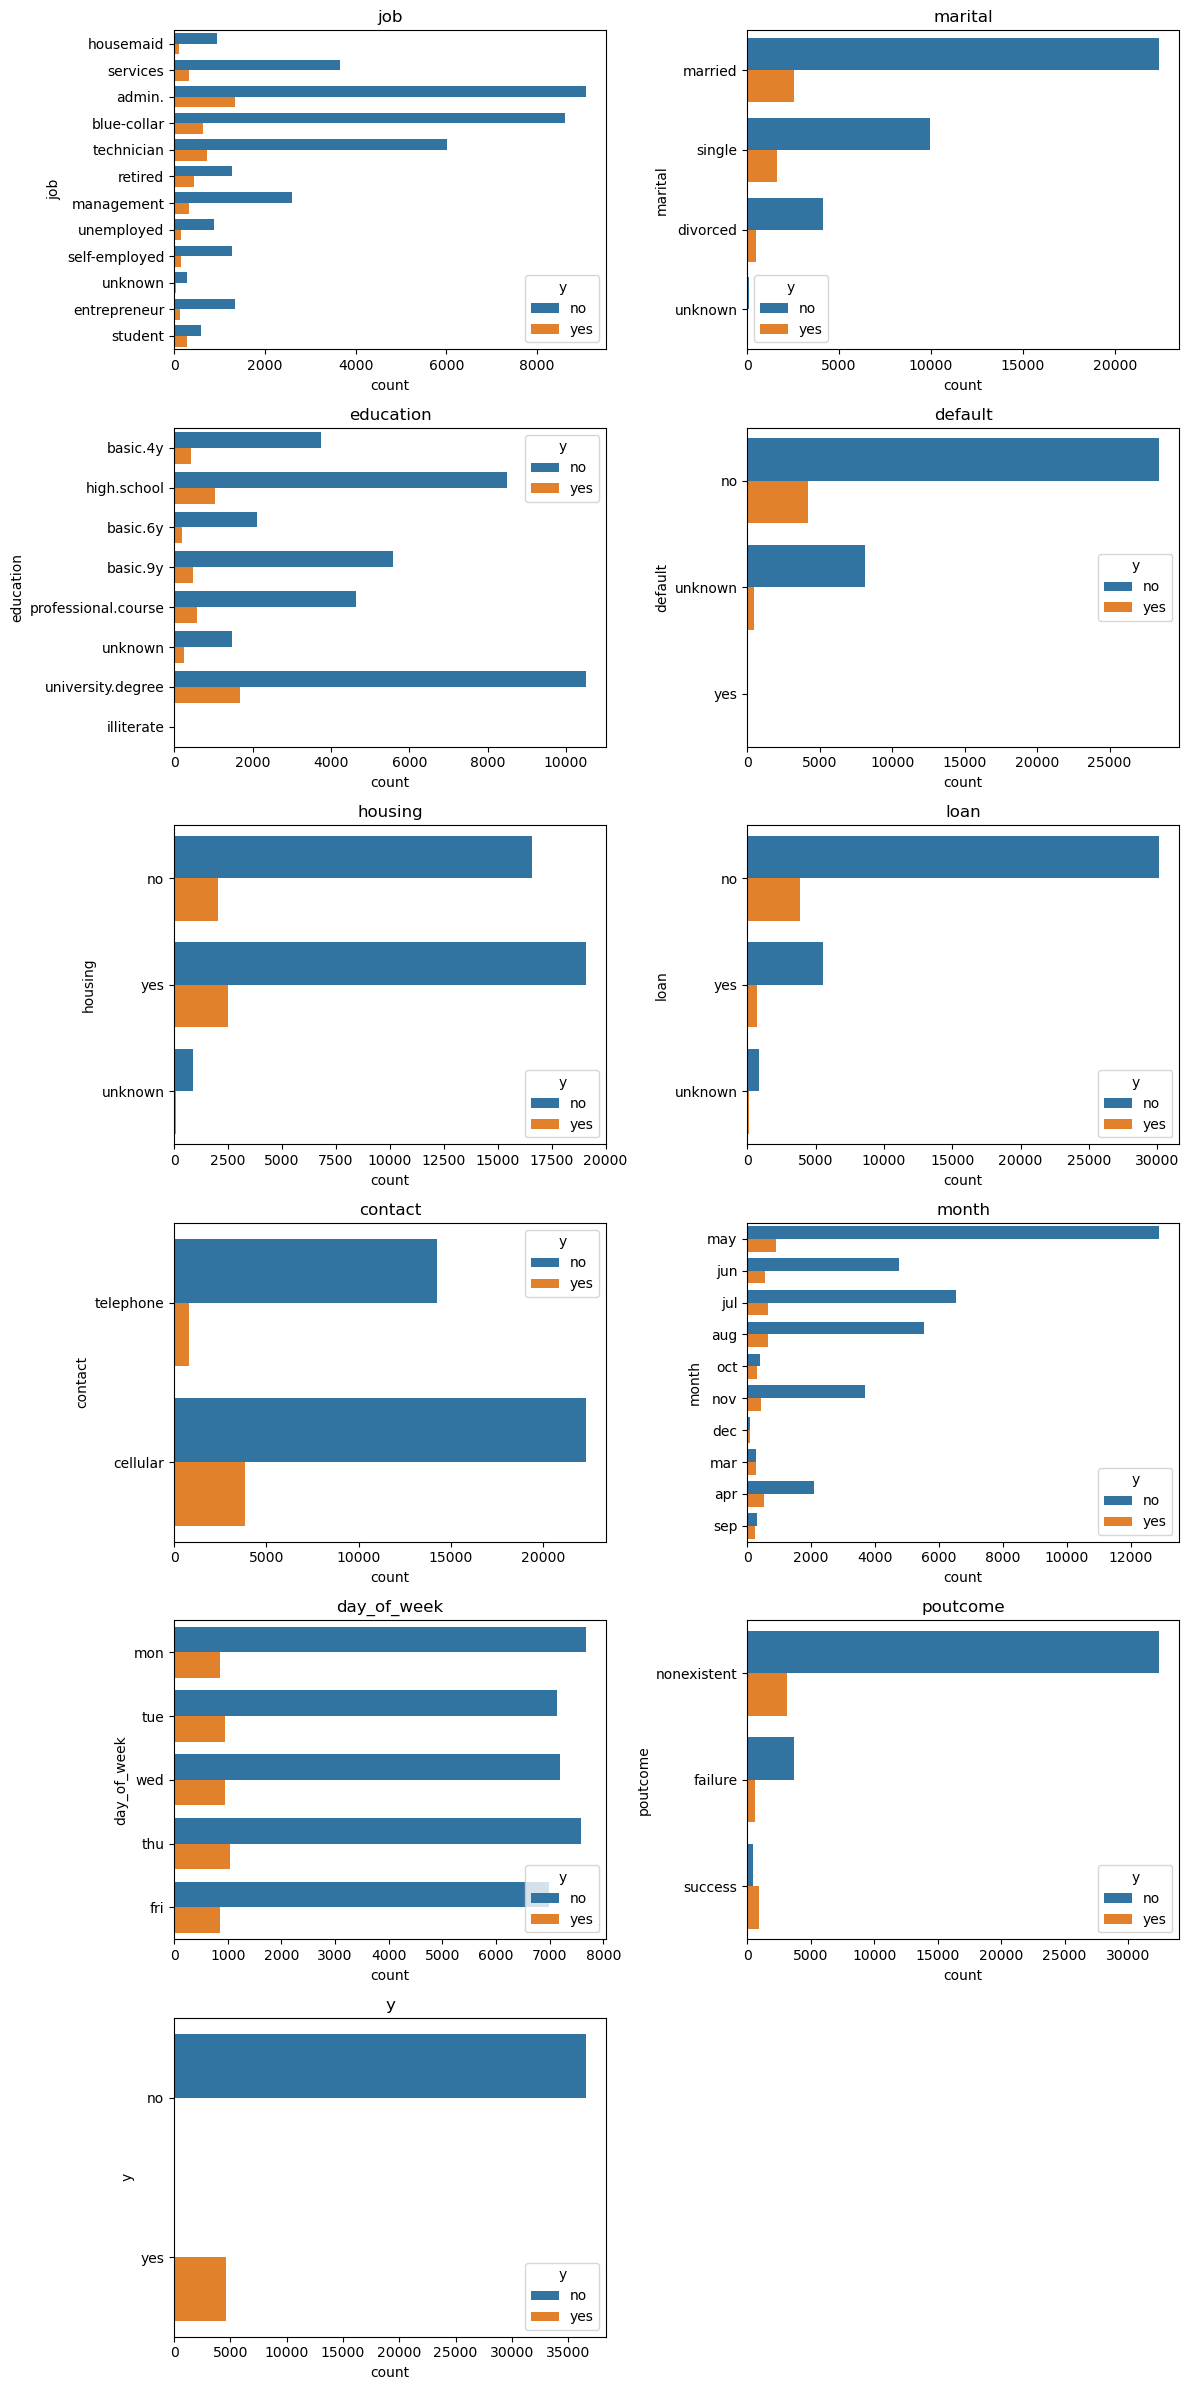

In [42]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of rows and columns in the grid
num_rows = math.ceil(len(category_columns) / 2)
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12*2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the category_columns and create grouped horizontal bar plots in subplots
for i, col in enumerate(category_columns):
    sns.countplot(data=df, y=col, hue='y', ax=axes[i])
    axes[i].set_title(col)

# Remove any empty subplots if the number of columns is odd
if len(category_columns) % 2 == 1:
    fig.delaxes(axes[-1])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


### Numeric columns visualization

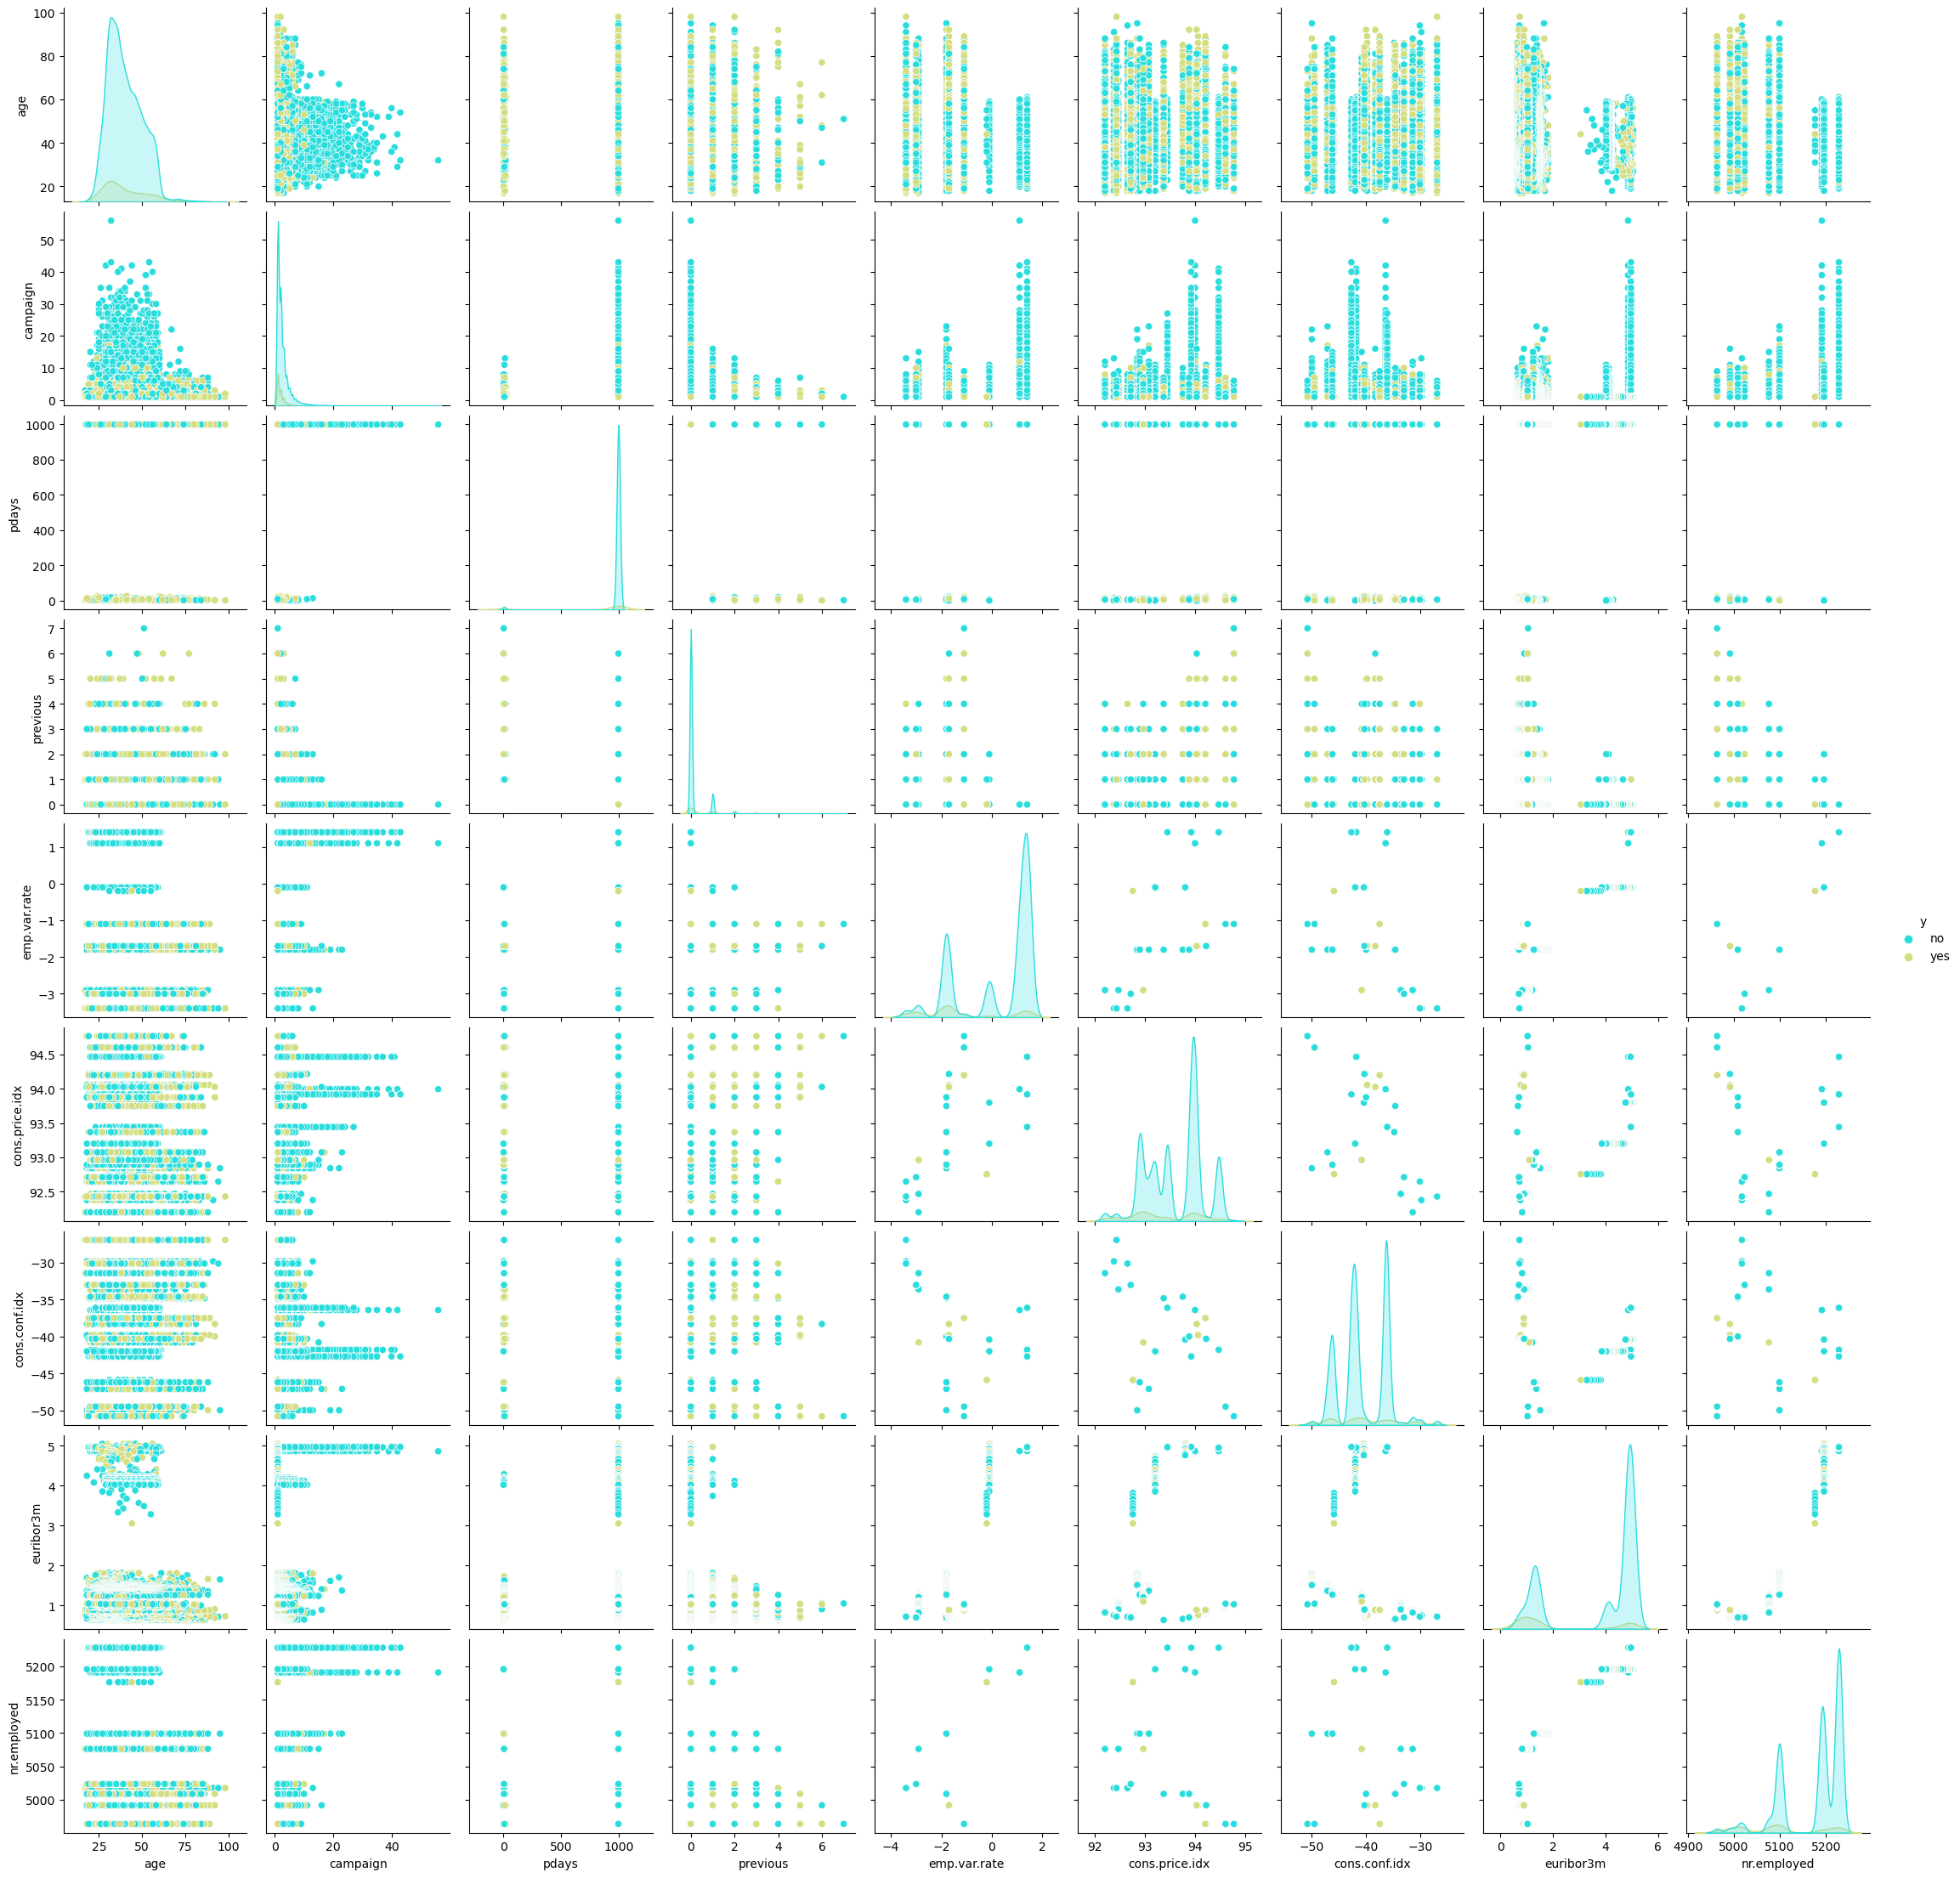

In [43]:
sns.pairplot(df, hue="y", palette="rainbow")

Maybe 'age' on 'campaign' could be usefull.
We will add it as new product column later.

### Principal Component analysis

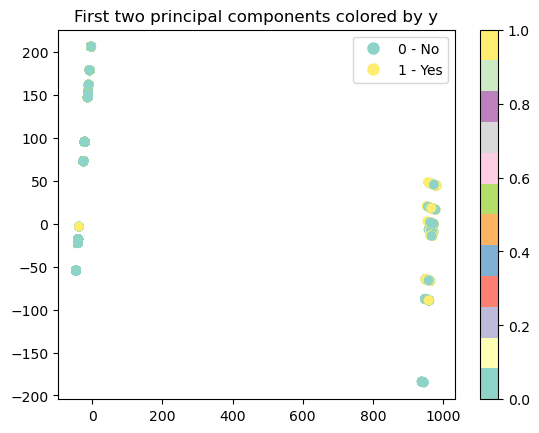

In [44]:
from sklearn.decomposition import PCA
import numpy as np

X = df.select_dtypes(include='number')
y = df['y'].to_numpy()
y = np.vectorize({'no':0,'yes':1}.get)(y)
pca = PCA(2)
pca.fit(X)
X_proj = pca.transform(X)

plt.scatter(X_proj[:,0], X_proj[:,1], c = y, cmap='Set3')
plt.title('First two principal components colored by y')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#8dd3c7', markersize=10, label='0 - No'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffed6f', markersize=10, label='1 - Yes')])
plt.colorbar()
plt.show()

### Data Carpentry

#### Splitting and Filling NA

In [45]:
try:
    df.replace('unknown', pd.NA, inplace=True)
except Exception as e:
    pass


In [46]:
import math
n_test = math.ceil(df.shape[0]*0.3)
df_full = df.dropna()

In [47]:
# Randomly sample rows for the df_full
df_test = df_full.sample(n=n_test, random_state=42)

# Create the df_train by excluding the rows in df_test
df_train = df.drop(df_test.index)

# Reset the index for both DataFrames
df_test.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [48]:
#Replace <NA> with median or mode
for column in df_full.columns:
    if pd.api.types.is_numeric_dtype(df_full[column]):
        # For numeric columns, replace with median
        median_value = df_full[column].median()
        df_train[column].fillna(median_value, inplace=True)
    else:
        # For non-numeric (categorical) columns, replace with mode
        mode_value = df_full[column].mode().iloc[0]
        df_train[column].fillna(mode_value, inplace=True)

#### SMOTE-NC oversampling

In [49]:
positive1 = df_train['y'][df_train['y'] == 'yes'].count()
pos_pr1 = positive1/df_train.shape[0]
print(f'Before oversampling. Positive signal: {round(pos_pr1,4)*100}%')

Before oversampling. Positive signal: 10.66%


In [50]:
from imblearn.over_sampling import SMOTENC

X_temp = df_train.drop('y', axis=1)
y_temp = df_train['y']

categorical_feature_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 13]
# Instantiate SMOTENC
smotenc = SMOTENC(categorical_features=categorical_feature_indices, sampling_strategy=0.5, random_state=42)

X_resampled, y_resampled = smotenc.fit_resample(X_temp, y_temp)

In [51]:
print(pd.Series(y_temp).value_counts())
print(pd.Series(y_resampled).value_counts())

no     25759
yes     3072
Name: y, dtype: int64
no     25759
yes    12879
Name: y, dtype: int64


In [52]:
X_resampled['y'] = y_resampled
df_train2 = X_resampled

In [53]:
positive2 = df_train2['y'][df_train2['y'] == 'yes'].count()
pos_pr2 = positive2/df_train2.shape[0]
print(f'After oversampling. Positive signal: {round(pos_pr2,4)*100}%')

After oversampling. Positive signal: 33.33%


In [54]:
df_train = df_train2

#### Encoding

In [55]:
df_train['pdays'].replace(999, -1, inplace=True)
df_test['pdays'].replace(999, -1, inplace=True)

In [56]:
# Binarize no/yes
cols_to_binarize = ['y', 'default', 'housing', 'loan']
for col in cols_to_binarize:
    df_train[col].replace({'no': 0, 'yes' : 1}, inplace=True)
    df_test[col].replace({'no': 0, 'yes' : 1}, inplace=True)

In [57]:
# Encode education levels
education_levels = {'illiterate':0, 'basic.4y':0.1666, 'basic.6y':2*0.1666, 'basic.9y':3*0.1666,
                    'high.school':4*0.1666,'professional.course':5*0.1666, 'university.degree':1}
df_train['education'].replace(education_levels, inplace=True)
df_test['education'].replace(education_levels, inplace=True)

In [58]:
import numpy as np
# Encode 'day_of_week' as sin and cos columns
weekday_dict = {'mon' : 1, 'tue' : 2, 'wed' : 3, 'thu' : 4 , 'fri' : 5} 
df_train['day_of_week'].replace(weekday_dict, inplace=True)
df_test['day_of_week'].replace(weekday_dict, inplace=True)

df_train['sin_weekday'] = np.sin(2 * np.pi * df_train['day_of_week'] / 7)
df_train['cos_weekday'] = np.cos(2 * np.pi * df_train['day_of_week'] / 7)
df_test['sin_weekday'] = np.sin(2 * np.pi * df_test['day_of_week'] / 7)
df_test['cos_weekday'] = np.cos(2 * np.pi * df_test['day_of_week'] / 7)

df_train.drop('day_of_week', axis=1, inplace=True)
df_test.drop('day_of_week', axis=1, inplace=True)

In [59]:
# Encode 'month' as sin and cos columns
month_dict = {'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12, 'mar':3, 'apr':4,'sep':9}
df_train['month'].replace(month_dict, inplace=True)
df_test['month'].replace(month_dict, inplace=True)

df_train['sin_month'] = np.sin(2 * np.pi * df_train['month'] / 12)
df_train['cos_month'] = np.cos(2 * np.pi * df_train['month'] / 12)
df_test['sin_month'] = np.sin(2 * np.pi * df_test['month'] / 12)
df_test['cos_month'] = np.cos(2 * np.pi * df_test['month'] / 12)

df_train.drop('month', axis=1, inplace=True)
df_test.drop('month', axis=1, inplace=True)

In [60]:
# Create a product column
df_train['prod_age_campaign'] = df_train['age'] * df_train['campaign']
df_test['prod_age_campaign'] = df_test['age'] * df_test['campaign']

In [61]:
# Standartization
from sklearn.preprocessing import StandardScaler
cols_to_standartize =['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                      'cons.conf.idx', 'euribor3m', 'nr.employed', 'prod_age_campaign']

# Standardization (zero mean and unit variance)
scaler = StandardScaler()
df_train[cols_to_standartize] = scaler.fit_transform(df_train[cols_to_standartize])
df_test[cols_to_standartize] = scaler.transform(df_test[cols_to_standartize])

In [62]:
# Dummify categoric variables without evident progression
cols_to_dummify = ['job', 'marital', 'contact', 'poutcome']
df_train = pd.get_dummies(df_train, columns=cols_to_dummify)
df_test  = pd.get_dummies(df_test , columns=cols_to_dummify)

In [63]:
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

X_test = df_test.drop('y', axis=1)
y_test = df_test['y']

### Logistic regression

#### Logistic search

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score



# Define a list of max_iter values to iterate through
max_iter_values = range(10, 21)

# Initialize empty lists to store train and test recall values
train_recall_values = []
test_recall_values = []

# Iterate over different max_iter values
for max_iter in max_iter_values:
    # Create a Logistic Regression model with the current max_iter value
    model = LogisticRegression(max_iter=max_iter, random_state=42, class_weight='balanced')
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate and store the recall scores for train and test sets
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    train_recall_values.append(train_recall)
    test_recall_values.append(test_recall)

# Plot the train and test recall values for different max_iter values
plt.figure(figsize=(10, 6))
plt.plot(max_iter_values, train_recall_values, marker='o', label='Train Recall')
plt.plot(max_iter_values, test_recall_values, marker='o', label='Test Recall')
plt.title('Train and Test Recall vs. max_iter')
plt.xlabel('max_iter')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()
```

#### Best Logistic

In [65]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=14, class_weight='balanced')
log_model.fit(X_train, y_train)

c:\Users\mazas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=14)

In [66]:
y_pred_train = log_model.predict(X_train)
y_pred_test = log_model.predict(X_test)

In [67]:
import numpy as np

score = pd.DataFrame(columns=['model', 'Train set acc', 'Test set acc'])
score.loc[len(score)] = ['Logistic Reg', f'{round(np.mean(y_train == y_pred_train)*100,2)}%', f'{round(np.mean(y_test == y_pred_test)*100,2)}%']

### Decision tree

#### Tree search

```python
from sklearn.metrics import accuracy_score
max_depth_values = range(1, 10)  # Change the range as needed

# Initialize lists to store training and testing accuracies
train_accuracies = []
test_accuracies = []

# Loop over max_depth values
for max_depth in max_depth_values:
    # Create and train a DecisionTreeClassifier
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the training and testing sets
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Calculate and store the training and testing accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the training and testing accuracies as a function of max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_accuracies, label='Train Accuracy')
plt.plot(max_depth_values, test_accuracies, label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Classifier Accuracy vs. max_depth')
plt.legend()
plt.grid(True)
plt.show()
```

#### Best tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
# Fit on train data
tree_model.fit(X_train, y_train)

# Make prediction and evaluate performance
y_pred_train2 = tree_model.predict(X_train)
y_pred_test2 = tree_model.predict(X_test)

score.loc[len(score)] = ['Decision tree', f'{round(np.mean(y_train == y_pred_train2)*100,2)}%', f'{round(np.mean(y_test == y_pred_test2)*100,2)}%']

### Random forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(1000, criterion = 'entropy', max_depth=30, max_features='sqrt', bootstrap=True, min_samples_leaf=5)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, max_features='sqrt',
                       min_samples_leaf=5, n_estimators=1000)

In [70]:
y_pred_train3 = rf.predict(X_train)
y_pred_test3 = rf.predict(X_test)

score.loc[len(score)] = ['Random forest', f'{round(np.mean(y_train == y_pred_train3)*100,2)}%', f'{round(np.mean(y_test == y_pred_test3)*100,2)}%']

### Comparison

In [71]:
score

,model,Train set acc,Test set acc
0,Logistic Reg,77.09%,75.9%
1,Decision tree,80.83%,87.45%
2,Random forest,91.18%,87.42%


In [72]:
from sklearn.metrics import confusion_matrix

confusion_matrix1 = confusion_matrix(y_test, y_pred_test)
confusion_matrix2 = confusion_matrix(y_test, y_pred_test2)
confusion_matrix3 = confusion_matrix(y_test, y_pred_test3)

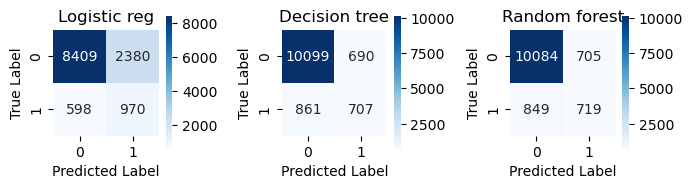

In [73]:
plt.figure(figsize=(7, 2))

# Plot the first confusion matrix
plt.subplot(131)
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues', square = True)
plt.title('Logistic reg')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot the second confusion matrix
plt.subplot(132)
sns.heatmap(confusion_matrix2, annot=True, fmt='d', cmap='Blues', square = True)
plt.title('Decision tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot the third confusion matrix
plt.subplot(133)
sns.heatmap(confusion_matrix3, annot=True, fmt='d', cmap='Blues', square = True)
plt.title('Random forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [74]:
dict = {}

for i, matrix in enumerate((confusion_matrix1, confusion_matrix2, confusion_matrix3), start=1):
    TN, FP, FN, TP = matrix.ravel()
    dict[f'precision{i}'] = f'{round(TP / (TP + FP) * 100, 2)}%'
    dict[f'recall{i}'] = f'{round(TP / (TP + FN) * 100, 2)}%'

In [75]:
df_pr_re = pd.DataFrame(
    [
        ['Logistic reg', dict['precision1'], dict['recall1']],
        ['Decision Tree', dict['precision2'], dict['recall2']],
        ['Random Forest', dict['precision3'], dict['recall3']]
    ],
    columns=['model', 'precision', 'recall']
)
df_pr_re

,model,precision,recall
0,Logistic reg,28.96%,61.86%
1,Decision Tree,50.61%,45.09%
2,Random Forest,50.49%,45.85%


### Comments

 - Precision is about minimizing false positives. It is essential when the cost or impact of false positives is high.
 - Recall is about minimizing false negatives. It is important when missing positive cases has serious consequences.
 - Ussualy it is a trade-off between the two. 

I recommend a model with the __highest recall__ (in this case logistic reg), that way a bussiness would be less likely to miss out on potential buyers.
Furthermore, the cost of calling a potential buyer is minimal compared to the profit.

Tiny positive signal harms models' performance.
We could try following techniques together or separately:
- oversampling with different methods (We did try it with SMOTE-NC), 
- undersampling,
- plainly dropping negative rows.